In [1]:
# Тюнинг
import optuna as opt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from helpers.validation import valid_predictions

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

# Данные
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from imblearn.over_sampling import RandomOverSampler
from helpers.data import DataPreprocessor

%matplotlib inline

In [2]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

def save_submission(model, subname):
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    preds = model.predict(test_df)
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)

# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
train_df = train_df.drop_duplicates()
test_df = pd.read_csv(TEST_DATASET)

X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Нормализация для кв/тестов
X_train = pd.concat([X_train, y_train], axis=1)

X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [7]:
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X_train, y_train)
best_params = {
    'learning_rate': 0.2, 
    'n_estimators': 2000, 
    'max_depth': 18, 
    'max_bin': 256, 
    'max_leaves': 220,
    'reg_lambda': 0.2,
    }

# Модель
data_preprocessor = DataPreprocessor()
model = XGBClassifier(
    **best_params,
    n_jobs=-1,
    tree_method='gpu_hist',
    random_state=42,
)

pipeline = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model)
])

In [8]:
%time
pipeline.fit(X_res, y_res)

CPU times: total: 0 ns
Wall time: 0 ns


Pipeline(steps=[('data_preproc', DataPreprocessor()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=256, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=18, max_leaves=220,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=2000,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [9]:
preds = pipeline.predict(X_test)


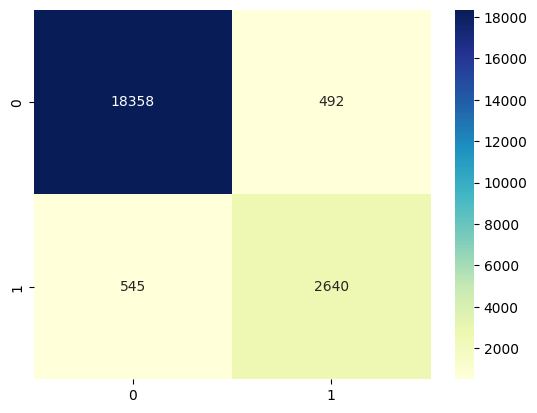

              precision    recall  f1-score   support

           0    0.97117   0.97390   0.97253     18850
           1    0.84291   0.82889   0.83584      3185

    accuracy                        0.95294     22035
   macro avg    0.90704   0.90139   0.90419     22035
weighted avg    0.95263   0.95294   0.95277     22035

0.9041858907926726
0.9013923022790019


In [10]:
valid_predictions(y_test, preds)

In [7]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.9027120099128112
0.8898121582850647


In [11]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.903897829141728
0.8952510479186759


In [9]:
save_submission(pipeline, 'submission_xgb')